In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pymc3 as pm
import arviz as az



import torch
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, init_to_mean


In [2]:
## Join data

features = pd.read_csv('data/dengue_features_train.csv')
labels   = pd.read_csv('data/dengue_labels_train.csv')

df = features.copy()

df['total_cases'] = labels.total_cases

# Target is in column 'total_cases'

In [3]:
df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [4]:
cities = list(df.city.unique())

sj_df = df.loc[df.city=='sj']

data_df = sj_df.copy()

data_df = data_df.dropna()

for c in data_df.columns:
    if c not in ('total_cases', 'city', 'year', 'weekofyear', 'week_start_date'):
        m, std, mm = data_df[c].mean(), data_df[c].std(), data_df[c].max()
        data_df[c] = (data_df[c]- m)/std


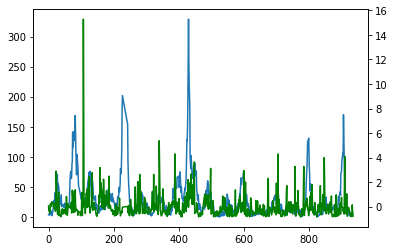

In [5]:
plt.plot()

ax1 = data_df.total_cases.plot()
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))

data_df.reanalysis_precip_amt_kg_per_m2.plot(ax=ax2, color='green')


plt.show()


In [6]:
sub_df = data_df.loc[:]

In [7]:
with pm.Model() as simple_model:
    b0 = pm.Normal("b0_intercept", mu=0, sigma=2)
    b1 = pm.Normal("b1_variable",  mu=0, sigma=2)
    b2 = pm.Normal("b2_variable",  mu=0, sigma=2)
    b3 = pm.Normal("b3_variable",  mu=0, sigma=2)
    b4 = pm.Normal("b4_variable",  mu=0, sigma=2)
    
    θ  = (
        b0
        + b1 * sub_df.reanalysis_precip_amt_kg_per_m2
        + b2 * sub_df.station_diur_temp_rng_c
        + b3 * sub_df.reanalysis_max_air_temp_k
        + b4 * sub_df.station_precip_mm
    ) 
    
    y = pm.Poisson("y", mu=np.exp(θ), observed=sub_df.total_cases)


In [8]:
#start = {'b0_intercept': 5., 'b1_variable': 1., 'b2_variable': 1., 'b3_variable': 1., 'b4_variable': 1.}
with simple_model:
    step = pm.Slice()
    inf_model = pm.sample(10000, step=step,  return_inferencedata=True,)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [b4_variable]
>Slice: [b3_variable]
>Slice: [b2_variable]
>Slice: [b1_variable]
>Slice: [b0_intercept]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 30 seconds.


array([[<AxesSubplot:title={'center':'b0_intercept'}>,
        <AxesSubplot:title={'center':'b0_intercept'}>],
       [<AxesSubplot:title={'center':'b1_variable'}>,
        <AxesSubplot:title={'center':'b1_variable'}>],
       [<AxesSubplot:title={'center':'b2_variable'}>,
        <AxesSubplot:title={'center':'b2_variable'}>],
       [<AxesSubplot:title={'center':'b3_variable'}>,
        <AxesSubplot:title={'center':'b3_variable'}>],
       [<AxesSubplot:title={'center':'b4_variable'}>,
        <AxesSubplot:title={'center':'b4_variable'}>]], dtype=object)

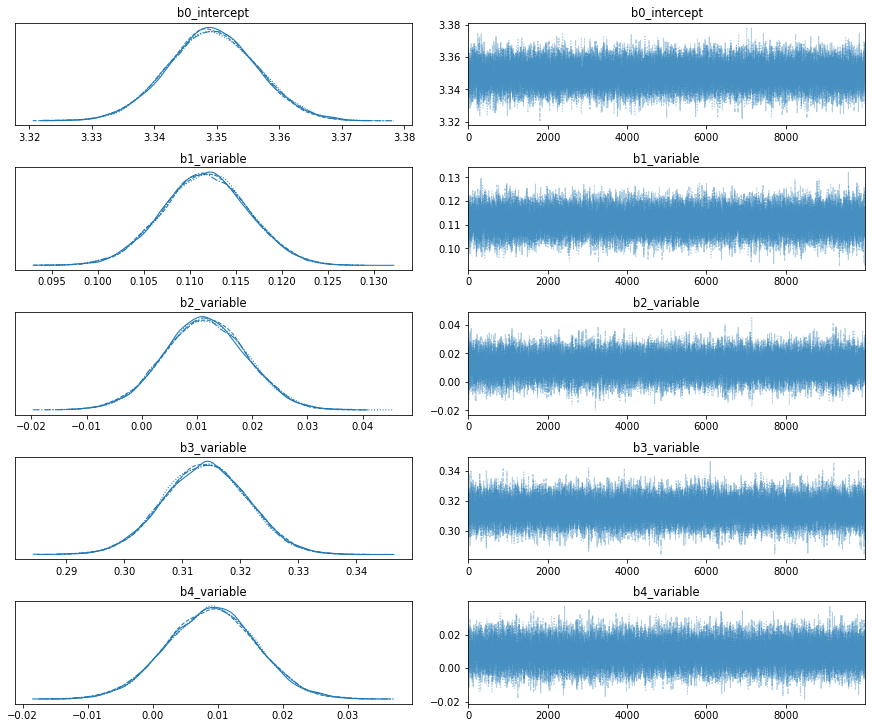

In [9]:
az.plot_trace(inf_model)

## Variational Inference approach

In [10]:
torch.set_default_dtype(torch.float64)

cols = ['reanalysis_precip_amt_kg_per_m2', 'station_diur_temp_rng_c', 'reanalysis_max_air_temp_k', 'station_precip_mm']

x_data = torch.tensor(data_df[cols].values).float()
y_data = torch.tensor(data_df.total_cases.values).float()


In [110]:
M = len(cols)


def model(x_data, y_data):
    b  = pyro.sample('b', dist.Normal(0.0, 2.0))    
    w  = pyro.sample('w', dist.Normal(0.0, 2.0).expand([M]).to_event(1))

    with pyro.plate('observe_data', size=len(y_data), subsample_size=80) as ind:
        θ = (x_data.index_select(0, ind) * w).sum(axis=1) + b
        pyro.sample('obs', dist.Poisson(θ.exp()), obs=y_data.index_select(0, ind)) 

guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

In [111]:
pyro.clear_param_store()

adam = Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

n_steps = 1000
losses = []


# do gradient steps
for step in range(n_steps):
    losses.append(svi.step(x_data, y_data))
    if step %100 == 0:
        print("Done with step {}".format(step))

Done with step 0
Done with step 100
Done with step 200
Done with step 300
Done with step 400
Done with step 500
Done with step 600
Done with step 700
Done with step 800
Done with step 900


In [112]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoMultivariateNormal.loc Parameter containing:
tensor([ 3.3403, -0.0609, -0.0780,  0.3340,  0.0794])
AutoMultivariateNormal.scale_tril tensor([[ 0.0487,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.1211,  0.0438,  0.0000,  0.0000,  0.0000],
        [ 0.0060, -0.0174,  0.0294,  0.0000,  0.0000],
        [ 0.0026,  0.0100, -0.0301,  0.0348,  0.0000],
        [ 0.0816, -0.0916, -0.0178,  0.0218,  0.0257]])


Text(0.5, 1.0, 'ELBO loss')

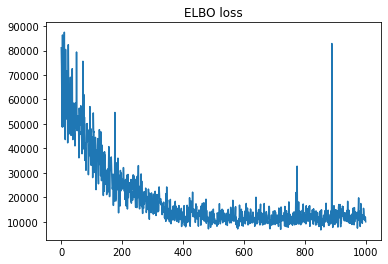

In [113]:
plt.plot(losses)
plt.title('ELBO loss')